<CENTER><img src="../../images/ATLASOD.gif" style="width:50%"></CENTER>

# How to rediscover the Higgs boson yourself!
This notebook uses ATLAS Open Data http://opendata.atlas.cern to show you the steps to rediscover the Higgs boson yourself!

ATLAS Open Data provides open access to proton-proton collision data at the LHC for educational purposes. ATLAS Open Data resources are ideal for high-school, undergraduate and postgraduate students.

Notebooks are web applications that allow you to create and share documents that can contain for example:
1. live code
2. visualisations
3. narrative text

The idea is that cuts increase the ratio of signal ($H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$) to background ($Z, t\bar{t}, ZZ \rightarrow \ell\ell\ell\ell$)

First, the amount of $Z$ and $t\bar{t}$ background is reduced, since these are quite different to the signal.

Then, the amount of $ZZ \rightarrow \ell\ell\ell\ell$ is reduced, whilst keeping as much $H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$ signal as possible.

The datasets used in this notebook have already been filtered to include at least 4 leptons per event, so that processing is quicker.

This analysis loosely follows the [discovery of the Higgs boson by ATLAS](https://www.sciencedirect.com/science/article/pii/S037026931200857X) (mostly Section 4 and 4.1)

By the end of this notebook you will be able to:
1. rediscover the Higgs boson yourself!
2. know some general principles of a particle physics analysis

Feynman diagram pictures are borrowed from our friends at https://www.particlezoo.net

<CENTER><img src="images/feynman_diagrams/HZZ_feynman.png" style="width:40%"></CENTER>

<a id='contents'></a>

Contents: 

[Running a Jupyter notebook](#running) <br />
[First time setup on your computer (no need on mybinder)](#setup_computer) <br />
[To setup everytime](#setup_everytime) <br />
[Lumi, fraction, file path](#fraction) <br />
[Samples](#samples) <br />
[Changing a cut](#changing_cut) <br />
[Applying a cut](#applying_cut) <br />
[Plotting](#plotting) <br />
[What can you do to explore this analysis?](#going_further) <br />

<a id='running'></a>

## Running a Jupyter notebook

To run the whole Jupyter notebook, in the top menu click Cell -> Run All.

To propagate a change you've made to a piece of code, click Cell -> Run All Below.

You can also run a single code cell, by clicking Cell -> Run Cells, or using the keyboard shortcut Shift+Enter.

<a id='setup_computer'></a>

## First time setup on your computer (no need on mybinder)
This first cell only needs to be run the first time you open this notebook on your computer. 

If you close Jupyter and re-open on the same computer, you won't need to run this first cell again.

If you open on mybinder, you don't need to run this cell.

In [ ]:
import sys
!{sys.executable} -m pip install --upgrade --user pip # update the pip package installer
!{sys.executable} -m pip install uproot pandas numpy matplotlib --user # install required packages

[Back to contents](#contents)

<a id='setup_everytime'></a>

## To setup everytime
Cell -> Run All Below

to be done every time you re-open this notebook

We're going to be using a number of tools to help us:
* uproot: lets us read .root files typically used in particle physics into data formats used in python
* pandas: lets us store data as dataframes, a format widely used in python
* numpy: provides numerical calculations such as histogramming
* matplotlib: common tool for making plots, figures, images, visualisations

In [25]:
import uproot # for reading .root files
import pandas as pd # to store data as dataframe
import time # to measure time to analyse
import math # for mathematical functions such as square root
import numpy as np # for numerical calculations such as histogramming
import matplotlib.pyplot as plt # for plotting
from matplotlib.ticker import AutoMinorLocator # for minor ticks

import infofile # local file containing cross-sections, sums of weights, dataset IDs

[Back to contents](#contents)

<a id='fraction'></a>

## Lumi, fraction, file path

General definitions of fraction of data used, where to access the input files

In [26]:
#lumi = 0.5 # fb-1 # data_A only
#lumi = 1.9 # fb-1 # data_B only
#lumi = 2.9 # fb-1 # data_C only
#lumi = 4.7 # fb-1 # data_D only
lumi = 10 # fb-1 # data_A,data_B,data_C,data_D

fraction = 1 # reduce this is you want the code to run quicker
                                                                                                                                  
#tuple_path = "Input/4lep/" # local 
tuple_path = "https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/4lep/" # web address

<a id='samples'></a>

## Samples

samples to process

In [27]:
samples = {

    'data': {
        'list' : ['data_A','data_B','data_C','data_D'],
    },

    r'Background $Z,t\bar{t}$' : { # Z + ttbar
        'list' : ['Zee','Zmumu','ttbar_lep'],
        'color' : "#6b59d3" # purple
    },

    r'Background $ZZ^*$' : { # ZZ
        'list' : ['llll'],
        'color' : "#ff0000" # red
    },

    r'Signal ($m_H$ = 125 GeV)' : { # H -> ZZ -> llll
        'list' : ['ggH125_ZZ4lep','VBFH125_ZZ4lep','WH125_ZZ4lep','ZH125_ZZ4lep'],
        'color' :["#00cdff" # light blue,
                 ,"#229944" # green
                 ,"#ffe631" # yellow
                 ,"#945219" # brown 
                 ]   
    },

}

[Back to contents](#contents)

Define function to get data from files.

The datasets used in this notebook have already been filtered to include at least 4 leptons per event, so that processing is quicker.

In [28]:
def get_data_from_files():

    data = {} # define empty dictionary to hold dataframes
    for s in samples: # loop over samples
        print('Processing '+s+' samples') # print which sample
        frames = [] # define empty list to hold data
        for val in samples[s]['list']: # loop over each file
            if s == 'data': prefix = "Data/" # Data prefix
            else: # MC prefix
                prefix = "MC/mc_"+str(infofile.infos[val]["DSID"])+"."
            fileString = tuple_path+prefix+val+".4lep.root" # file name to open
            temp = read_file(fileString,val) # call the function read_file defined below
            frames.append(temp) # append dataframe returned from read_file to list of dataframes
        if s ==  r'Signal ($m_H$ = 125 GeV)':
            data[s] = pd.concat(frames,keys=['ggH125_ZZ4lep','VBFH125_ZZ4lep','WH125_ZZ4lep','ZH125_ZZ4lep'])    
        else:
            data[s] = pd.concat(frames) # dictionary entry is concatenated dataframes
    
    return data # return dictionary of dataframes

[Back to contents](#contents)

define function to calculate weight of MC event

In [29]:
def calc_weight(xsec_weight, mcWeight, scaleFactor_PILEUP,
                scaleFactor_ELE, scaleFactor_MUON, 
                scaleFactor_LepTRIGGER ):
    return xsec_weight*mcWeight*scaleFactor_PILEUP*scaleFactor_ELE*scaleFactor_MUON*scaleFactor_LepTRIGGER

define function to get cross-section weight

In [30]:
def get_xsec_weight(sample):
    info = infofile.infos[sample] # open infofile
    xsec_weight = (lumi*1000*info["xsec"])/(info["sumw"]*info["red_eff"]) #*1000 to go from fb-1 to pb-1
    return xsec_weight # return cross-section weight

define function to calculate 4-lepton invariant mass

In [31]:
def calc_mllll(lep_pt,lep_eta,lep_phi,lep_E):
    # first lepton is [0], 2nd lepton is [1] etc
    px_0 = lep_pt[0]*math.cos(lep_phi[0]) # x-component of lep[0] momentum
    py_0 = lep_pt[0]*math.sin(lep_phi[0]) # y-component of lep[0] momentum
    pz_0 = lep_pt[0]*math.sinh(lep_eta[0]) # z-component of lep[0] momentum
    px_1 = lep_pt[1]*math.cos(lep_phi[1]) # x-component of lep[1] momentum
    py_1 = lep_pt[1]*math.sin(lep_phi[1]) # y-component of lep[1] momentum
    pz_1 = lep_pt[1]*math.sinh(lep_eta[1]) # z-component of lep[1] momentum
    px_2 = lep_pt[2]*math.cos(lep_phi[2]) # x-component of lep[2] momentum
    py_2 = lep_pt[2]*math.sin(lep_phi[2]) # y-component of lep[2] momentum
    pz_2 = lep_pt[2]*math.sinh(lep_eta[2]) # z-component of lep[3] momentum
    px_3 = lep_pt[3]*math.cos(lep_phi[3]) # x-component of lep[3] momentum
    py_3 = lep_pt[3]*math.sin(lep_phi[3]) # y-component of lep[3] momentum
    pz_3 = lep_pt[3]*math.sinh(lep_eta[3]) # z-component of lep[3] momentum
    sumpx = px_0 + px_1 + px_2 + px_3 # x-component of 4-lepton momentum
    sumpy = py_0 + py_1 + py_2 + py_3 # y-component of 4-lepton momentum
    sumpz = pz_0 + pz_1 + pz_2 + pz_3 # z-component of 4-lepton momentum
    sumE = lep_E[0] + lep_E[1] + lep_E[2] + lep_E[3] # energy of 4-lepton system
    return math.sqrt(sumE**2 - sumpx**2 - sumpy**2 - sumpz**2)/1000 #/1000 to go from MeV to GeV

In [32]:
def calc_M12M34(lep_pt,lep_eta,lep_phi,lep_E,lep_type):
    idx_e=[]
    idx_mu=[]
    for i in range(4):
        if lep_type[i] == 11:
            idx_e.append(i)  
        elif lep_type[i] == 13:
            idx_mu.append(i)
    
    e1 = idx_e[0]
    e2 = idx_e[1]
    mu1 = idx_mu[0]
    mu2 = idx_mu[1]
    
    px_e1 = lep_pt[e1]*math.cos(lep_phi[e1]) # x-component of lep[0] momentum
    py_e1 = lep_pt[e1]*math.sin(lep_phi[e1]) # y-component of lep[0] momentum
    pz_e1 = lep_pt[e1]*math.sinh(lep_eta[e1]) # z-component of lep[0] momentum
    
    px_e2 = lep_pt[e2]*math.cos(lep_phi[e2]) # x-component of lep[1] momentum
    py_e2 = lep_pt[e2]*math.sin(lep_phi[e2]) # y-component of lep[1] momentum
    pz_e2 = lep_pt[e2]*math.sinh(lep_eta[e2]) # z-component of lep[1] momentum
    
    px_mu1= lep_pt[mu1]*math.cos(lep_phi[mu1]) # x-component of lep[2] momentum
    py_mu1= lep_pt[mu1]*math.sin(lep_phi[mu1]) # y-component of lep[2] momentum
    pz_mu1= lep_pt[mu1]*math.sinh(lep_eta[mu1]) # z-component of lep[3] momentum
    
    px_mu2 = lep_pt[mu2]*math.cos(lep_phi[mu2]) # x-component of lep[3] momentum
    py_mu2 = lep_pt[mu2]*math.sin(lep_phi[mu2]) # y-component of lep[3] momentum
    pz_mu2= lep_pt[mu2]*math.sinh(lep_eta[mu2]) # z-component of lep[3] momentum
    
    sumpx_e = px_e1 + px_e2  # x-component of 4-lepton momentum
    sumpy_e = py_e1 + py_e2  # y-component of 4-lepton momentum
    sumpz_e = pz_e1 + pz_e2  # z-component of 4-lepton momentum
    sumE_e = lep_E[e1] + lep_E[e2]  
    
    sumpx_mu = px_mu1 + px_mu2  # x-component of 4-lepton momentum
    sumpy_mu = py_mu1 + py_mu2  # y-component of 4-lepton momentum
    sumpz_mu = pz_mu1 + pz_mu2  # z-component of 4-lepton momentum
    sumE_mu = lep_E[mu1] + lep_E[mu2] 
    
    Mee = math.sqrt(sumE_e**2 - sumpx_e**2 - sumpy_e**2 - sumpz_e**2)/1000 #/1000 to go from MeV to GeV
    Mmumu = math.sqrt(sumE_mu**2 - sumpx_mu**2 - sumpy_mu**2 - sumpz_mu**2)/1000 #/1000 to go from MeV to GeV
    
    MZ = 91.1876 #(Gev) mass of Z boson
    
    if abs(MZ - Mee) < abs(MZ - Mmumu):
        M12 = Mee
        M34 = Mmumu
    else:
        M12 = Mmumu
        M34 = Mee
    return M12,M34
def calc_m12(lep_pt,lep_eta,lep_phi,lep_E,lep_type):
    return calc_M12M34(lep_pt,lep_eta,lep_phi,lep_E,lep_type)[0]
def calc_m34(lep_pt,lep_eta,lep_phi,lep_E,lep_type):
    return calc_M12M34(lep_pt,lep_eta,lep_phi,lep_E,lep_type)[1]

[Back to contents](#contents)

<a id='changing_cut'></a>

## Changing a cut

If you change a cut: Cell -> Run All Below

If you change a cut here, you also need to make sure the cut is applied in the "[Applying a cut](#applying_cut)" cell.

In [33]:
# cut on lepton charge
# paper: "selecting two pairs of isolated leptons, each of which is comprised of two leptons with the same flavour and opposite charge"
def cut_lep_charge(lep_charge):
# throw away when sum of lepton charges is not equal to 0
# first lepton is [0], 2nd lepton is [1] etc
    return lep_charge[0] + lep_charge[1] + lep_charge[2] + lep_charge[3] != 0

# cut on lepton type
# paper: "selecting two pairs of isolated leptons, each of which is comprised of two leptons with the same flavour and opposite charge"
def cut_lep_type(lep_type):
# for an electron lep_type is 11
# for a muon lep_type is 13
# throw away when none of eeee, mumumumu, eemumu
    sum_lep_type = lep_type[0] + lep_type[1] + lep_type[2] + lep_type[3]
    return (sum_lep_type != 44) and (sum_lep_type != 48) and (sum_lep_type != 52)

def cut2_lep_type(lep_type):
# for an electron lep_type is 11
# for a muon lep_type is 13
# throw away when none of eemumu
    sum_lep_type = lep_type[0] + lep_type[1] + lep_type[2] + lep_type[3]
    return sum_lep_type != 48

[Back to contents](#contents)

<a id='applying_cut'></a>

## Applying a cut
If you add a cut: Cell -> Run All Below

In [34]:
def read_file(path,sample):
    start = time.time() # start the clock
    print("\tProcessing: "+sample) # print which sample is being processed
    data_all = pd.DataFrame() # define empty pandas DataFrame to hold all data for this sample
    tree = uproot.open(path)["mini"] # open the tree called mini
    numevents = uproot.numentries(path, "mini") # number of events
    if 'data' not in sample: xsec_weight = get_xsec_weight(sample) # get cross-section weight
    for data in tree.iterate(['lep_pt','lep_eta','lep_phi',
                              'lep_E','lep_charge','lep_type', 
                              # add more variables here if you make cuts on them 
                              'mcWeight','scaleFactor_PILEUP',
                              'scaleFactor_ELE','scaleFactor_MUON',
                              'scaleFactor_LepTRIGGER'], # variables to calculate Monte Carlo weight
                             outputtype=pd.DataFrame, # choose output type as pandas DataFrame
                             entrystop=numevents*fraction): # process up to numevents*fraction

        nIn = len(data.index) # number of events in this batch

        if 'data' not in sample: # only do this for Monte Carlo simulation files
            # multiply all Monte Carlo weights and scale factors together to give total weight
            data['totalWeight'] = np.vectorize(calc_weight)(xsec_weight,
                                                            data.mcWeight,
                                                            data.scaleFactor_PILEUP,
                                                            data.scaleFactor_ELE,
                                                            data.scaleFactor_MUON,
                                                            data.scaleFactor_LepTRIGGER)

        # cut on lepton charge using the function cut_lep_charge defined above
        fail = data[ np.vectorize(cut_lep_charge)(data.lep_charge) ].index
        data.drop(fail, inplace=True)

        # cut on lepton type using the function cut_lep_type defined above
        fail = data[ np.vectorize(cut2_lep_type)(data.lep_type) ].index
        data.drop(fail, inplace=True)

        # calculation of 4-lepton invariant mass using the function calc_mllll defined above
        data['mllll'] = np.vectorize(calc_mllll)(data.lep_pt,data.lep_eta,data.lep_phi,data.lep_E)
        
        data['m12'] = np.vectorize(calc_m12)(data.lep_pt,data.lep_eta,data.lep_phi,data.lep_E,data.lep_type)
        data['m34'] = np.vectorize(calc_m34)(data.lep_pt,data.lep_eta,data.lep_phi,data.lep_E,data.lep_type)

        # dataframe contents can be printed at any stage like this
        #print(data)

        # dataframe column can be printed at any stage like this
        #print(data['lep_pt'])

        # multiple dataframe columns can be printed at any stage like this
        #print(data[['lep_pt','lep_eta']])

        nOut = len(data.index) # number of events passing cuts in this batch
        data_all = data_all.append(data) # append dataframe from this batch to the dataframe for the whole sample
        elapsed = time.time() - start # time taken to process
        print("\t\t nIn: "+str(nIn)+",\t nOut: \t"+str(nOut)+"\t in "+str(round(elapsed,1))+"s") # events before and after
    
    return data_all # return dataframe containing events passing all cuts

[Back to contents](#contents)

This is where the processing happens

In [35]:
start = time.time() # time at start of whole processing
data = get_data_from_files() # process all files
elapsed = time.time() - start # time after whole processing
print("Time taken: "+str(round(elapsed,1))+"s") # print total time taken to process every file

Processing data samples
	Processing: data_A
		 nIn: 39,	 nOut: 	16	 in 0.2s
	Processing: data_B
		 nIn: 156,	 nOut: 	41	 in 0.3s
	Processing: data_C
		 nIn: 237,	 nOut: 	84	 in 0.3s
	Processing: data_D
		 nIn: 400,	 nOut: 	149	 in 0.4s
Processing Background $Z,t\bar{t}$ samples
	Processing: Zee
		 nIn: 898,	 nOut: 	157	 in 0.8s
	Processing: Zmumu
		 nIn: 684,	 nOut: 	144	 in 0.6s
	Processing: ttbar_lep
		 nIn: 1031,	 nOut: 	279	 in 0.8s
Processing Background $ZZ^*$ samples
	Processing: llll
		 nIn: 106415,	 nOut: 	58042	 in 28.7s
		 nIn: 106415,	 nOut: 	57936	 in 42.3s
		 nIn: 106415,	 nOut: 	57875	 in 56.1s
		 nIn: 106415,	 nOut: 	58034	 in 69.7s
		 nIn: 106415,	 nOut: 	58057	 in 82.7s
		 nIn: 22204,	 nOut: 	12155	 in 85.2s
Processing Signal ($m_H$ = 125 GeV) samples
	Processing: ggH125_ZZ4lep
		 nIn: 104555,	 nOut: 	61051	 in 47.2s
		 nIn: 60161,	 nOut: 	35289	 in 54.2s
	Processing: VBFH125_ZZ4lep
		 nIn: 102038,	 nOut: 	59305	 in 43.7s
		 nIn: 89088,	 nOut: 	51843	 in 56.9s
	Process

[Back to contents](#contents)

In [36]:
print()

<a id='plotting'></a>

## Plotting
If you only want a make a change in plotting: Cell -> Run All Below

Define function to plot the data

In [37]:
def plot_data(data):

    xmin = 80 # GeV
    xmax = 250 # GeV
    step_size = 5 # GeV

    bin_edges = np.arange(start=xmin, # The interval includes this value
                     stop=xmax+step_size, # The interval doesn't include this value
                     step=step_size ) # Spacing between values
    bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                            stop=xmax+step_size/2, # The interval doesn't include this value
                            step=step_size ) # Spacing between values

    data_x,_ = np.histogram(data['data']['mllll'], 
                            bins=bin_edges ) # histogram the data
    data_x_errors = np.sqrt( data_x ) # statistical error on the data
    
    sig_x = []
    sig_weights = []
    sig_colors = []
    sig_labels = []
    for idx,s in enumerate (samples[r'Signal ($m_H$ = 125 GeV)']["list"]):
        sig_x.append(data[r'Signal ($m_H$ = 125 GeV)'].loc[s]['mllll']) # histogram the signal
        sig_weights.append(data[r'Signal ($m_H$ = 125 GeV)'].loc[s]["totalWeight"]) # get the weights of the signal events
        sig_colors.append(samples[r'Signal ($m_H$ = 125 GeV)']['color'][idx]) # get the colour for the signal bar
        sig_labels.append(s)
    
    mc_x = [] # define list to hold the Monte Carlo histogram entries
    mc_weights = [] # define list to hold the Monte Carlo weights
    mc_colors = [] # define list to hold the colors of the Monte Carlo bars
    mc_labels = [] # define list to hold the legend labels of the Monte Carlo bars

    for s in samples: # loop over samples
        if s not in ['data', r'Signal ($m_H$ = 125 GeV)']: # if not data nor signal
            mc_x.append( data[s]['mllll'] ) # append to the list of Monte Carlo histogram entries
            mc_weights.append( data[s].totalWeight ) # append to the list of Monte Carlo weights
            mc_colors.append( samples[s]['color'] ) # append to the list of Monte Carlo bar colors
            mc_labels.append( s ) # append to the list of Monte Carlo legend labels
    
    total_x = mc_x + sig_x
    total_weights = mc_weights +  sig_weights
    total_colors = mc_colors + sig_colors
    total_labels  = mc_labels  + sig_labels 
    


    # *************
    # Main plot 
    # *************
    main_axes = plt.gca() # get current axes
    mc_total_x = pd.concat([mc_x[0],mc_x[1]],ignore_index=True)
    mc_total_weights = pd.concat([mc_weights[0],mc_weights[1]],ignore_index=True)
    mc_heights = np.histogram(mc_total_x, bins=bin_edges, 
                         weights=mc_total_weights
                            )
    
    mc_x_tot = mc_heights[0] # stacked background MC y-axis value
    mc_x_err = np.sqrt( mc_x_tot ) # statistical error on the MC bars
    # plot the data points
    main_axes.errorbar(x=bin_centres, y=data_x, yerr=data_x_errors,
                       fmt='ko', # 'k' means black and 'o' is for circles 
                       label='Data') 
    
    # plot the Monte Carlo and sig bars
    main_axes.hist(total_x, 
                   bins=bin_edges, 
                   weights=total_weights, 
                   stacked=True, 
                   color=total_colors, 
                   label=total_labels )
 

    
    #plot the statistical uncertainty
    main_axes.bar(bin_centres, # x
                  2*mc_x_err, # heights
                  alpha=0.5, # half transparency
                  bottom=mc_x_tot-mc_x_err,
                  color='none', 
                  hatch="////", width=step_size, label='Stat. Unc.' )

    # set the x-limit of the main axes
    main_axes.set_xlim( left=xmin, right=xmax ) 
    
    # separation of x axis minor ticks
    main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # set the axis tick parameters for the main axes
    main_axes.tick_params(which='both', # ticks on both x and y axes
                          direction='in', # Put ticks inside and outside the axes
                          top=True, # draw ticks on the top axis
                          right=True ) # draw ticks on right axis
    
    # x-axis label
    main_axes.set_xlabel(r'4-lepton invariant mass $\mathrm{m_{4l}}$ [GeV]',
                        fontsize=13, x=1, horizontalalignment='right' )
    
    # write y-axis label for main axes
    main_axes.set_ylabel('Events / '+str(step_size)+' GeV',
                         y=1, horizontalalignment='right') 
    
    # set y-axis limits for main axes
    main_axes.set_ylim( bottom=0, top=np.amax(data_x)*1.6 )
    
    # add minor ticks on y-axis for main axes
    main_axes.yaxis.set_minor_locator( AutoMinorLocator() ) 

    # Add text 'ATLAS Open Data' on plot
    plt.text(0.05, # x
             0.93, # y
             'ATLAS Open Data', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             fontsize=13 ) 
    
    # Add text 'for education' on plot
    plt.text(0.05, # x
             0.88, # y
             'for education', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             style='italic',
             fontsize=8 ) 
    
    # Add energy and luminosity
    lumi_used = str(lumi*fraction) # luminosity to write on the plot
    plt.text(0.05, # x
             0.82, # y
             '$\sqrt{s}$=13 TeV,$\int$L dt = '+lumi_used+' fb$^{-1}$', # text
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes
    
    # Add a label for the analysis carried out
    plt.text(0.05, # x
             0.76, # y
             r'$H \rightarrow ZZ^* \rightarrow 4\ell$', # text 
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes

    # draw the legend
    main_axes.legend( frameon=False ) # no box around the legend
    
    return

[Back to contents](#contents)

Call the function to plot the data

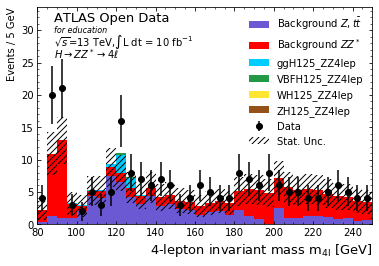

In [38]:
plot_data(data)
plt.savefig("m4l_all")

[Back to contents](#contents)

<a id='going_further'></a>

## What can you do to explore this analysis?

* Increase the fraction of data used in '[Lumi, fraction, file path](#fraction)'
* Check how many events are being thrown away by each cut in '[Applying a cut](#applying_cut)'
* Add more cuts from the [Higgs discovery paper](https://www.sciencedirect.com/science/article/pii/S037026931200857X#se0040) in '[Changing a cut](#changing_cut)' and '[Applying a cut](#applying_cut)'
* Add a plot to show the ratio between Data and MC other than Higgs
* Add a plot to show the invariant mass distribution of the sub-leading lepton pair, like [Figure 1 of the Higgs discovery paper](https://www.sciencedirect.com/science/article/pii/S037026931200857X#fg0010)
* Get the estimated numbers of events, like [Table 3 of the Higgs discovery paper](https://www.sciencedirect.com/science/article/pii/S037026931200857X#tl0030)
* Add a plot of m12 against m34, like [Figure 3 of the Higgs discovery paper](https://www.sciencedirect.com/science/article/pii/S037026931200857X#fg0030)
* Your idea!

[Back to contents](#contents)

In [39]:
def plot_sig(data):

    xmin = 100 # GeV
    xmax = 140 # GeV
    step_size = 5 # GeV

    bin_edges = np.arange(start=xmin, # The interval includes this value
                     stop=xmax+step_size, # The interval doesn't include this value
                     step=step_size ) # Spacing between values
    bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                            stop=xmax+step_size/2, # The interval doesn't include this value
                            step=step_size ) # Spacing between values

   
    sig_x = []
    sig_weights = []
    sig_colors = []
    sig_labels = []
    for idx,s in enumerate (samples[r'Signal ($m_H$ = 125 GeV)']["list"]):
        sig_x.append(data[r'Signal ($m_H$ = 125 GeV)'].loc[s]['mllll']) # histogram the signal
        sig_weights.append(data[r'Signal ($m_H$ = 125 GeV)'].loc[s]["totalWeight"]) # get the weights of the signal events
        sig_colors.append(samples[r'Signal ($m_H$ = 125 GeV)']['color'][idx]) # get the colour for the signal bar
        sig_labels.append(s)
    
   
    


    # *************
    # Main plot 
    # *************
    main_axes = plt.gca() # get current axes
    
    # plot the Monte Carlo and sig bars
    main_axes.hist(sig_x, 
                   bins=bin_edges, 
                   weights=sig_weights, 
                   stacked=True, 
                   color=sig_colors, 
                   label=sig_labels )
 
    # set the x-limit of the main axes
    main_axes.set_xlim( left=xmin, right=xmax ) 
    
    # separation of x axis minor ticks
    main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # set the axis tick parameters for the main axes
    main_axes.tick_params(which='both', # ticks on both x and y axes
                          direction='in', # Put ticks inside and outside the axes
                          top=True, # draw ticks on the top axis
                          right=True ) # draw ticks on right axis
    
    # x-axis label
    main_axes.set_xlabel(r'4-lepton invariant mass $\mathrm{m_{4l}}$ [GeV]',
                        fontsize=13, x=1, horizontalalignment='right' )
    
    # write y-axis label for main axes
    main_axes.set_ylabel('Events / '+str(step_size)+' GeV',
                         y=1, horizontalalignment='right') 
    
    # set y-axis limits for main axes
    main_axes.set_ylim( bottom=0, top=7.5 )
    
    # add minor ticks on y-axis for main axes
    main_axes.yaxis.set_minor_locator( AutoMinorLocator() ) 

    # Add text 'ATLAS Open Data' on plot
    plt.text(0.05, # x
             0.93, # y
             'ATLAS Open Data', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             fontsize=13 ) 
    
    # Add text 'for education' on plot
    plt.text(0.05, # x
             0.88, # y
             'for education', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             style='italic',
             fontsize=8 ) 
    
    # Add energy and luminosity
    lumi_used = str(lumi*fraction) # luminosity to write on the plot
    plt.text(0.05, # x
             0.82, # y
             '$\sqrt{s}$=13 TeV,$\int$L dt = '+lumi_used+' fb$^{-1}$', # text
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes
    
    # Add a label for the analysis carried out
    plt.text(0.05, # x
             0.76, # y
             r'$H \rightarrow ZZ^* \rightarrow 4\ell$', # text 
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes

    # draw the legend
    main_axes.legend( frameon=False ,loc ='lower left') # no box around the legend
    
    return

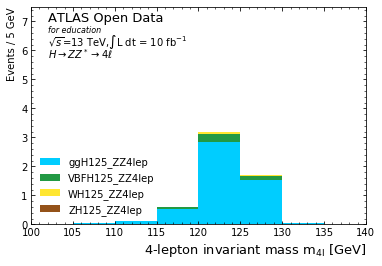

In [40]:
plot_sig(data)
plt.savefig("m4l_sig")

In [48]:
def plot_m12(data):

    xmin = 80 # GeV
    xmax = 100 # GeV
    step_size = 1 # GeV

    bin_edges = np.arange(start=xmin, # The interval includes this value
                     stop=xmax+step_size, # The interval doesn't include this value
                     step=step_size ) # Spacing between values
    bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                            stop=xmax+step_size/2, # The interval doesn't include this value
                            step=step_size ) # Spacing between values

    data_m12,_ = np.histogram(data['data']['m12'], 
                               bins=bin_edges ) # histogram the data
    data_m12_errors = np.sqrt( data_m12 ) # statistical error on the data
    
    sig_m12 = []
    sig_weights = []
    sig_colors = []
    sig_labels = []
    for idx,s in enumerate (samples[r'Signal ($m_H$ = 125 GeV)']["list"]):
        sig_m12.append(data[r'Signal ($m_H$ = 125 GeV)'].loc[s]['m12']) # histogram the signal
        sig_weights.append(data[r'Signal ($m_H$ = 125 GeV)'].loc[s]["totalWeight"]) # get the weights of the signal events
        sig_colors.append(samples[r'Signal ($m_H$ = 125 GeV)']['color'][idx]) # get the colour for the signal bar
        sig_labels.append(s)
    
    mc_m12 = [] # define list to hold the Monte Carlo histogram entries
    mc_weights = [] # define list to hold the Monte Carlo weights
    mc_colors = [] # define list to hold the colors of the Monte Carlo bars
    mc_labels = [] # define list to hold the legend labels of the Monte Carlo bars

    for s in samples: # loop over samples
        if s not in ['data', r'Signal ($m_H$ = 125 GeV)']: # if not data nor signal
            mc_m12.append( data[s]['m12'] ) # append to the list of Monte Carlo histogram entries
            mc_weights.append( data[s].totalWeight ) # append to the list of Monte Carlo weights
            mc_colors.append( samples[s]['color'] ) # append to the list of Monte Carlo bar colors
            mc_labels.append( s ) # append to the list of Monte Carlo legend labels
    
    total_m12 = mc_m12 + sig_m12
    total_weights = mc_weights +  sig_weights
    total_colors = mc_colors + sig_colors
    total_labels  = mc_labels  + sig_labels 
    


    # *************
    # Main plot 
    # *************
    main_axes = plt.gca() # get current axes
    mc_total_m12 = pd.concat([mc_m12[0],mc_m12[1]],ignore_index=True)
    mc_total_weights = pd.concat([mc_weights[0],mc_weights[1]],ignore_index=True)
    
    mc_m12_heights = np.histogram(mc_total_m12, bins=bin_edges, 
                                  weights=mc_total_weights
                                    )
    
    mc_m12_tot = mc_m12_heights[0] # stacked background MC y-axis value
    mc_m12_err = np.sqrt( mc_m12_tot ) # statistical error on the MC bars
    
    # plot the data points
    main_axes.errorbar(x=bin_centres, y=data_m12, yerr=data_m12_errors,
                       fmt='ko', # 'k' means black and 'o' is for circles 
                       label='Data') 
    
    # plot the Monte Carlo and sig bars
    main_axes.hist(total_m12, 
                   bins=bin_edges, 
                   weights=total_weights, 
                   stacked=True, 
                   color=total_colors, 
                   label=total_labels )
 

    
    #plot the statistical uncertainty
    main_axes.bar(bin_centres, # x
                  2*mc_m12_err, # heights
                  alpha=0.5, # half transparency
                  bottom=mc_m12_tot-mc_m12_err,
                  color='none', 
                  hatch="////", width=step_size, label='Stat. Unc.' )

    # set the x-limit of the main axes
    main_axes.set_xlim( left=xmin, right=xmax ) 
    
    # separation of x axis minor ticks
    main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # set the axis tick parameters for the main axes
    main_axes.tick_params(which='both', # ticks on both x and y axes
                          direction='in', # Put ticks inside and outside the axes
                          top=True, # draw ticks on the top axis
                          right=True ) # draw ticks on right axis
    
    # x-axis label
    main_axes.set_xlabel(r' $\mathrm{m_{12}}$ [GeV]',
                        fontsize=13, x=1, horizontalalignment='right' )
    
    # write y-axis label for main axes
    main_axes.set_ylabel('Events / '+str(step_size)+' GeV',
                         y=1, horizontalalignment='right') 
    
    # set y-axis limits for main axes
    main_axes.set_ylim( bottom=0, top=200 )
    
    # add minor ticks on y-axis for main axes
    main_axes.yaxis.set_minor_locator( AutoMinorLocator() ) 

    # Add text 'ATLAS Open Data' on plot
    plt.text(0.05, # x
             0.93, # y
             'ATLAS Open Data', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             fontsize=13 ) 
    
    # Add text 'for education' on plot
    plt.text(0.05, # x
             0.88, # y
             'for education', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             style='italic',
             fontsize=8 ) 
    
    # Add energy and luminosity
    lumi_used = str(lumi*fraction) # luminosity to write on the plot
    plt.text(0.05, # x
             0.82, # y
             '$\sqrt{s}$=13 TeV,$\int$L dt = '+lumi_used+' fb$^{-1}$', # text
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes
    
    # Add a label for the analysis carried out
    plt.text(0.05, # x
             0.76, # y
             r'$H \rightarrow ZZ^* \rightarrow 4\ell$', # text 
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes

    # draw the legend
    main_axes.legend( frameon=False,loc ='lower left'  ) # no box around the legend
    
    return

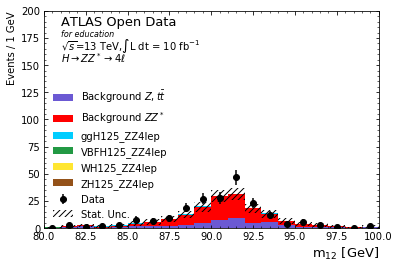

In [49]:
plot_m12(data)
plt.savefig("m12")

In [43]:
def plot_m34(data):

    xmin = 0 # GeVa
    xmax = 120 # GeV
    step_size = 5 # GeV

    bin_edges = np.arange(start=xmin, # The interval includes this value
                     stop=xmax+step_size, # The interval doesn't include this value
                     step=step_size ) # Spacing between values
    bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                            stop=xmax+step_size/2, # The interval doesn't include this value
                            step=step_size ) # Spacing between values

    data_m34,_ = np.histogram(data['data']['m34'], 
                               bins=bin_edges ) # histogram the data
    data_m34_errors = np.sqrt( data_m34 ) # statistical error on the data
    
    sig_m34 = []
    sig_weights = []
    sig_colors = []
    sig_labels = []
    for idx,s in enumerate (samples[r'Signal ($m_H$ = 125 GeV)']["list"]):
        sig_m34.append(data[r'Signal ($m_H$ = 125 GeV)'].loc[s]['m34']) # histogram the signal
        sig_weights.append(data[r'Signal ($m_H$ = 125 GeV)'].loc[s]["totalWeight"]) # get the weights of the signal events
        sig_colors.append(samples[r'Signal ($m_H$ = 125 GeV)']['color'][idx]) # get the colour for the signal bar
        sig_labels.append(s)
    
    mc_m34 = [] # define list to hold the Monte Carlo histogram entries
    mc_weights = [] # define list to hold the Monte Carlo weights
    mc_colors = [] # define list to hold the colors of the Monte Carlo bars
    mc_labels = [] # define list to hold the legend labels of the Monte Carlo bars

    for s in samples: # loop over samples
        if s not in ['data', r'Signal ($m_H$ = 125 GeV)']: # if not data nor signal
            mc_m34.append( data[s]['m34'] ) # append to the list of Monte Carlo histogram entries
            mc_weights.append( data[s].totalWeight ) # append to the list of Monte Carlo weights
            mc_colors.append( samples[s]['color'] ) # append to the list of Monte Carlo bar colors
            mc_labels.append( s ) # append to the list of Monte Carlo legend labels
    
    total_m34 = mc_m34 + sig_m34
    total_weights = mc_weights +  sig_weights
    total_colors = mc_colors + sig_colors
    total_labels  = mc_labels  + sig_labels 
    


    # *************
    # Main plot 
    # *************
    main_axes = plt.gca() # get current axes
    mc_total_m34 = pd.concat([mc_m34[0],mc_m34[1]],ignore_index=True)
    mc_total_weights = pd.concat([mc_weights[0],mc_weights[1]],ignore_index=True)
    
    mc_m34_heights = np.histogram(mc_total_m34, bins=bin_edges, 
                                  weights=mc_total_weights
                                    )
    
    mc_m34_tot = mc_m34_heights[0] # stacked background MC y-axis value
    mc_m34_err = np.sqrt( mc_m34_tot ) # statistical error on the MC bars
    
    # plot the data points
    main_axes.errorbar(x=bin_centres, y=data_m34, yerr=data_m34_errors,
                       fmt='ko', # 'k' means black and 'o' is for circles 
                       label='Data') 
    
    # plot the Monte Carlo and sig bars
    main_axes.hist(total_m34, 
                   bins=bin_edges, 
                   weights=total_weights, 
                   stacked=True, 
                   color=total_colors, 
                   label=total_labels )
 

    
    #plot the statistical uncertainty
    main_axes.bar(bin_centres, # x
                  2*mc_m34_err, # heights
                  alpha=0.5, # half transparency
                  bottom=mc_m34_tot-mc_m34_err,
                  color='none', 
                  hatch="////", width=step_size, label='Stat. Unc.' )

    # set the x-limit of the main axes
    main_axes.set_xlim( left=xmin, right=xmax ) 
    
    # separation of x axis minor ticks
    main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # set the axis tick parameters for the main axes
    main_axes.tick_params(which='both', # ticks on both x and y axes
                          direction='in', # Put ticks inside and outside the axes
                          top=True, # draw ticks on the top axis
                          right=True ) # draw ticks on right axis
    
    # x-axis label
    main_axes.set_xlabel(r' $\mathrm{m_{34}}$ [GeV]',
                        fontsize=13, x=1, horizontalalignment='right' )
    
    # write y-axis label for main axes
    main_axes.set_ylabel('Events / '+str(step_size)+' GeV',
                         y=1, horizontalalignment='right') 
    
    # set y-axis limits for main axes
    main_axes.set_ylim( bottom=0, top=50 )
    
    # add minor ticks on y-axis for main axes
    main_axes.yaxis.set_minor_locator( AutoMinorLocator() ) 

    # Add text 'ATLAS Open Data' on plot
    plt.text(0.05, # x
             0.93, # y
             'ATLAS Open Data', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             fontsize=13 ) 
    
    # Add text 'for education' on plot
    plt.text(0.05, # x
             0.88, # y
             'for education', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             style='italic',
             fontsize=8 ) 
    
    # Add energy and luminosity
    lumi_used = str(lumi*fraction) # luminosity to write on the plot
    plt.text(0.05, # x
             0.82, # y
             '$\sqrt{s}$=13 TeV,$\int$L dt = '+lumi_used+' fb$^{-1}$', # text
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes
    
    # Add a label for the analysis carried out
    plt.text(0.05, # x
             0.76, # y
             r'$H \rightarrow ZZ^* \rightarrow 4\ell$', # text 
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes

    # draw the legend
    main_axes.legend( frameon=False, bbox_to_anchor=(1.05, 1)  ) # no box around the legend
    
    return

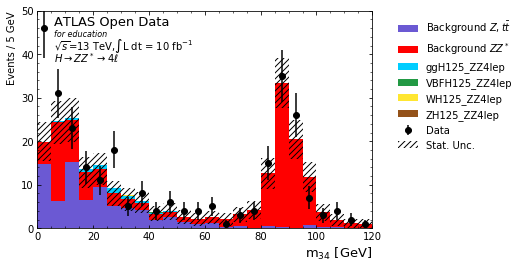

In [44]:
plot_m34(data)
plt.savefig("m34",bbox_inches='tight')

In [47]:
data[r'Signal ($m_H$ = 125 GeV)'].reset_index
print(data[r'Signal ($m_H$ = 125 GeV)'])

                                                                lep_pt  \
              entry                                                      
ggH125_ZZ4lep 2              [33646.71, 27313.271, 20035.95, 16472.64]   
              3             [77118.56, 27845.74, 17726.541, 14714.521]   
              7             [65800.67, 52887.168, 26791.57, 12736.506]   
              9            [88715.76, 26640.701, 21422.096, 12627.215]   
              10            [48422.46, 45139.477, 19089.47, 12431.967]   
              13           [44333.527, 39228.34, 33360.605, 10808.444]   
              16             [36348.3, 28705.281, 24643.842, 8550.508]   
              17           [46534.855, 44328.24, 17517.822, 13989.576]   
              18               [55073.508, 38980.18, 15590.25, 7623.3]   
              19            [66167.02, 47544.613, 39069.23, 34151.992]   
              21           [45942.16, 17431.969, 15595.737, 14123.431]   
              22           [62849.97, 